In [293]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from os import walk
from IPython.display import display
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.optimize import Bounds

In [6]:
path = '/environment/notebooks/timeseries/1._Лекция_tsml/Series/'
f = []
for (dirpath, dirnames, filenames) in walk(path):
    f.extend(filenames)
    break
print(f)

['daily-total-female-births-in-cal.csv', 'international-airline-passengers.csv', 'mean-monthly-air-temperature-deg.csv', 'monthly-boston-armed-robberies-j.csv', 'monthly-sales-of-company-x-jan-6.csv', 'weekly-closings-of-the-dowjones-.csv']


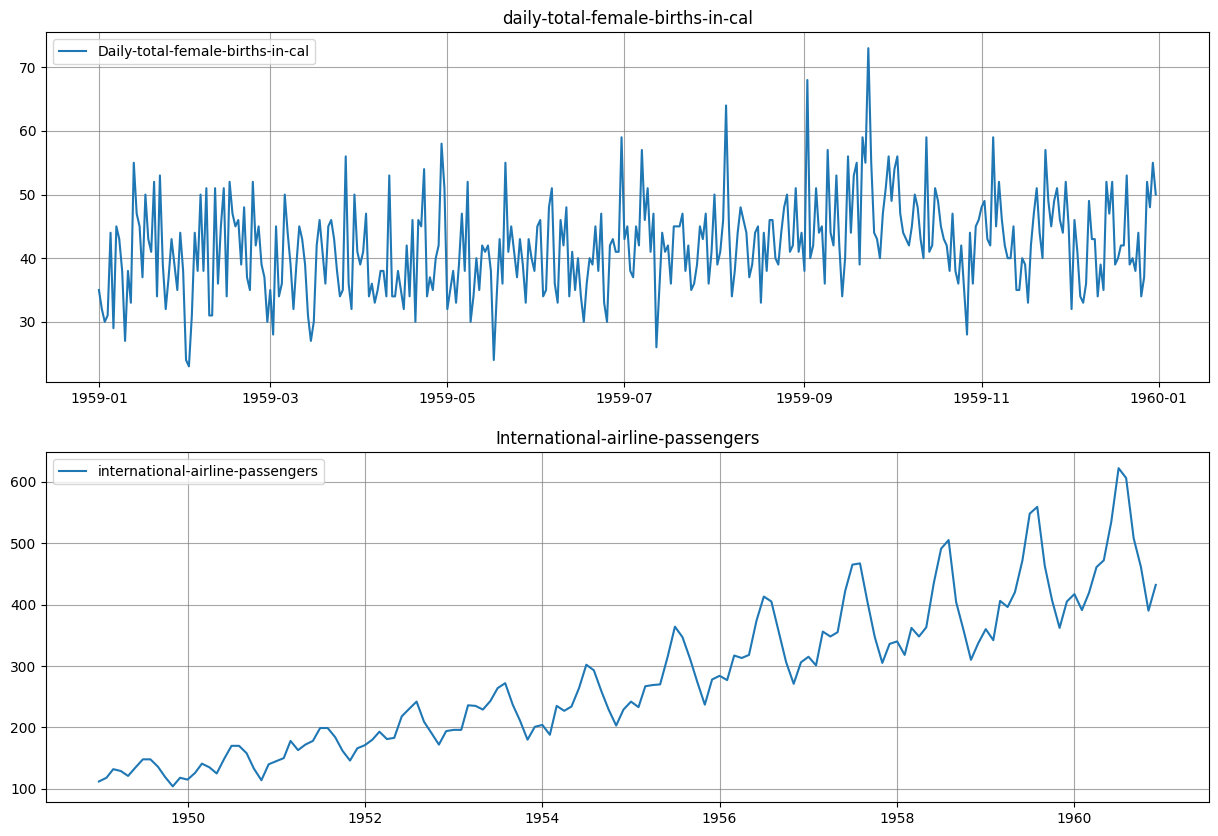

In [189]:

girls = pd.read_csv(path+'daily-total-female-births-in-cal.csv', parse_dates=True, index_col=0)
airline = pd.read_csv(path+'international-airline-passengers.csv', parse_dates=True, index_col=0)

def plot_initialize():
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize = (15, 10))
    ax0.grid(color = 'grey', alpha = 0.7, label = 'Inline Label')
    ax1.grid(color = 'grey', alpha = 0.7, label = 'Inline Label')
    return fig, ax0, ax1

fig, ax0, ax1 = plot_initialize()
girls_orig = ax0.plot(girls, label = 'Daily-total-female-births-in-cal')
airline_orig = ax1.plot(airline, label = 'international-airline-passengers')
ax0.set_title('daily-total-female-births-in-cal')
ax1.set_title('International-airline-passengers')
ax0.legend(loc = 'upper left')
ax1.legend(loc = 'upper left')
display(fig)

In [190]:
def wma_func(series, n, weights):
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

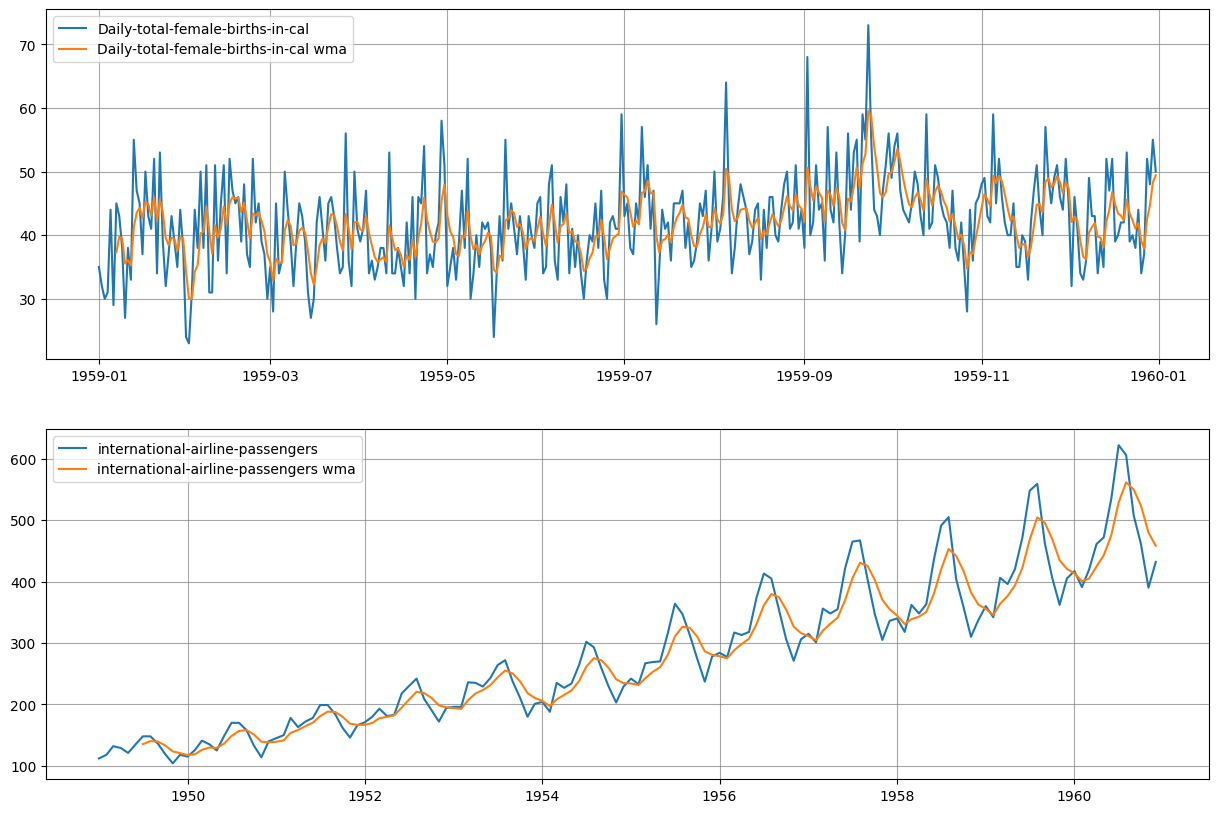

In [213]:
nums = np.array([0,2,4,6,8,12,16])

fig, ax0, ax1 = plot_initialize()
ax0.plot(girls, label = 'Daily-total-female-births-in-cal')
ax1.plot(airline, label = 'international-airline-passengers')
girls_wma = wma_func(girls.iloc[:,0], 7, nums)
airline_wma = wma_func(airline.iloc[:,0], 7, nums)
ax0.plot(girls_wma,label = 'Daily-total-female-births-in-cal wma')
ax1.plot(airline_wma, label = 'international-airline-passengers wma')
ax0.legend(loc = 'upper left')
ax1.legend(loc = 'upper left')
display(fig)


In [210]:
def ema_dema(ts, alpha, beta):
   ema = ts.iloc[:,0].ewm(alpha = alpha, adjust = False).mean()
   dema = 2*ema - ema.ewm(alpha = beta, adjust = False).mean()
   return ema, dema

def tema_func(ema, gamma):
   tema = 3*ema - 3*ema.ewm(alpha = gamma, adjust = False).mean() + ema.ewm(alpha = gamma, adjust = False).mean().ewm(alpha = gamma, adjust = False).mean()
   return tema


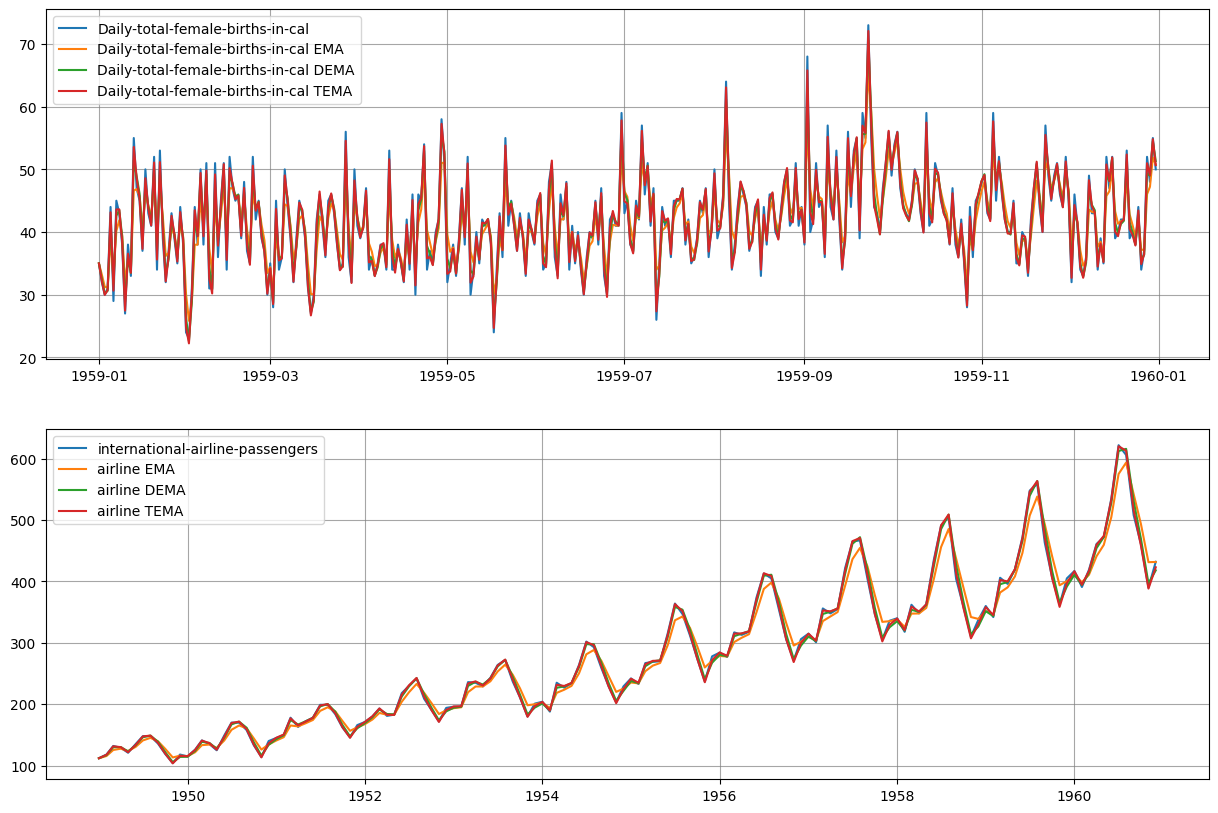

In [221]:
g_ema, g_dema = ema_dema(girls, 0.6, 0.6)
a_ema, a_dema = ema_dema(airline, 0.6, 0.6)
a_tema = tema_func(a_ema, 0.6)
g_tema = tema_func(g_ema, 0.6)

fig, ax0, ax1 = plot_initialize()
ax0.plot(girls, label = 'Daily-total-female-births-in-cal')
ax1.plot(airline, label = 'international-airline-passengers')

ax0.plot(g_ema,label = 'Daily-total-female-births-in-cal EMA')
ax0.plot(g_dema,label = 'Daily-total-female-births-in-cal DEMA')
ax0.plot(g_tema,label = 'Daily-total-female-births-in-cal TEMA')
ax1.plot(a_ema, label = 'airline EMA')
ax1.plot(a_dema, label = 'airline DEMA')
ax1.plot(a_tema, label = 'airline TEMA')
ax0.legend(loc = 'upper left')
ax1.legend(loc = 'upper left')
display(fig)

In [236]:
def train_test_splitter(ts):
    train, test = train_test_split(ts, test_size=0.2, shuffle=False)
    return train, test

In [254]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [252]:
def objective(params, *args, eval = 'dema'):
    alpha, beta, gamma = params
    ma = args[0]
    targets = args[1]
    ema, dema = ema_dema(ma, alpha, beta)
    tema = tema_func(ema, gamma)
    if eval == 'ema':
        return rmse(ema, targets)
    elif eval == 'dema':
        return rmse(dema, targets)
    elif eval == 'tema':
        return rmse(tema, targets)
    else:
       raise ValueError('Invalid evaluation type')


In [372]:
g_train, g_test = train_test_splitter(girls)
a_train, a_test = train_test_splitter(airline)

In [400]:
x0 = np.array([0.1, 0.1, 0.1])
bounds = Bounds([0.01, 0.01, 0.01], [0.85, 0.85, 0.85])

g_opt_dema = minimize(objective, x0, args= (g_train, g_train.iloc[:,0], 'dema'), method="Nelder-Mead", bounds = bounds)
a_opt_dema = minimize(objective, x0, args= (a_train, a_train.iloc[:,0], 'dema'), method='Nelder-Mead', bounds = bounds)

g_alpha_opt_dema, g_beta_opt_dema, g_gamma_opt_dema = g_opt_dema.x
a_alpha_opt_dema, a_beta_opt_dema, a_gamma_opt_dema = a_opt_dema.x

g_ema_opt, g_dema_opt = ema_dema(g_test, g_alpha_opt_dema, g_beta_opt_dema)
a_ema_opt, a_dema_opt = ema_dema(a_test, a_alpha_opt_dema, a_beta_opt_dema)

In [401]:
g_rmse_dema = rmse(g_dema_opt, g_test.iloc[:,0])
a_rmse_dema = rmse(a_dema_opt, a_test.iloc[:,0])

print("RMSE DEMA girls: ", g_rmse_dema)
print("RMSE DEMA airlines: ", a_rmse_dema)


RMSE DEMA girls:  0.1817233407962472
RMSE DEMA airlines:  1.3044970346755502


In [402]:
g_opt_tema = minimize(objective, x0, args= (g_train, g_train.iloc[:,0], 'tema'), method='Nelder-Mead', bounds = bounds)
a_opt_tema = minimize(objective, x0, args= (a_train, a_train.iloc[:,0], 'tema'), method='Nelder-Mead', bounds = bounds)

g_alpha_opt_tema, g_beta_opt_tema, g_gamma_opt_tema = g_opt_tema.x
a_alpha_opt_tema, a_beta_opt_tema, a_gamma_opt_tema = a_opt_tema.x

g_tema_opt = tema_func(g_ema_opt, g_gamma_opt_tema)
a_tema_opt = tema_func(a_ema_opt, a_gamma_opt_tema)

In [404]:
g_rmse_tema = rmse(g_tema_opt, g_test.iloc[:,0])
a_rmse_tema = rmse(a_tema_opt, a_test.iloc[:,0])

print("RMSE DEMA girls: ", g_rmse_dema)
print("RMSE DEMA airlines: ", a_rmse_dema)

RMSE DEMA girls:  0.1817233407962472
RMSE DEMA airlines:  1.3044970346755502


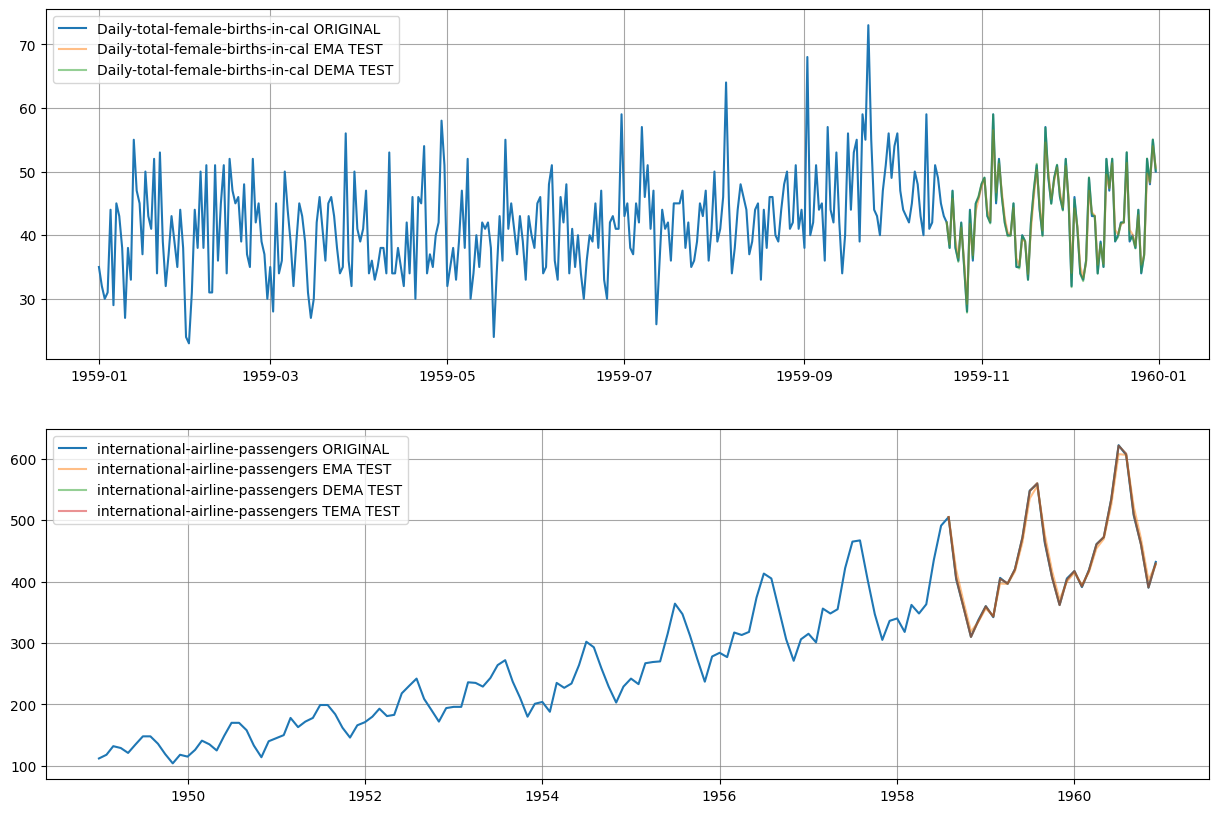

In [406]:
fig, ax0, ax1 = plot_initialize()
ax0.plot(girls, label = 'Daily-total-female-births-in-cal ORIGINAL', alpha = 1)
ax1.plot(airline, label = 'international-airline-passengers ORIGINAL', alpha = 1)

ax0.plot(g_ema_opt,label = 'Daily-total-female-births-in-cal EMA TEST', alpha = 0.5)
ax0.plot(g_dema_opt,label = 'Daily-total-female-births-in-cal DEMA TEST', alpha = 0.5)
# ax0.plot(g_tema_opt,label = 'Daily-total-female-births-in-cal TEMA TEST', alpha = 0.5)

ax1.plot(a_ema_opt, label = 'international-airline-passengers EMA TEST', alpha = 0.5)
ax1.plot(a_dema_opt, label = 'international-airline-passengers DEMA TEST', alpha = 0.5)
ax1.plot(a_dema_opt, label = 'international-airline-passengers TEMA TEST', alpha = 0.5)
ax0.legend(loc = 'upper left')
ax1.legend(loc = 'upper left')
display(fig)